# Example: Macro Parameter Optimization

This example notebook shows how to optimize some of the uncertain scalar parameters that govern an ESNs behavior.
We will:

- Establish data for training the readout weights, separate datasets to be used for the "macro_training" (i.e., parameter optimization) and testing

- Define a [xesn.CostFunction](generated/xesn.CostFunction.rst) that penalizes both NRMSE and error in terms of the Power Spectral Density (PSD)

- Use [xesn.optimize](generated/xesn.optimize.rst), which under the hood uses the [surrogate modeling toolbox](https://smt.readthedocs.io/en/latest/) to optimize the parameters

- Evaluate our optimized model over many samples from a test dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
plt.style.use("./xesn.mplstyle")

## Create training, macro training, and testing data

Note that we refer to the parameter optimization as `macro_training` because we are "training" the [macro scale parameters](methods.rst#macro-scale-parameters).

In [3]:
from lorenz import Lorenz96

In [4]:
model = Lorenz96(N=12)

In [5]:
n_spinup = 2_000
n_train = 40_000
n_macro_training = 10_000
n_transient = 5_000
n_test = 10_000

n_total = n_spinup+n_train+n_macro_training+n_transient + n_test
rs = np.random.RandomState(1)
trajectory = model.generate(n_steps=n_total, x0=rs.normal(size=(model.N,)))

In [6]:
trainer = trajectory.isel(time=slice(n_spinup, n_spinup+n_train+1))
macro_trainer = trajectory.isel(time=slice(n_spinup+n_train, n_spinup+n_train+n_macro_training+1))
tester = trajectory.isel(time=slice(-n_test-1, None))

### Normalization

In [7]:
bias = trainer.mean()
scale = trainer.std()

normalize = lambda xda : (xda - bias) / scale

with xr.set_options(keep_attrs=True):
    trainer = normalize(trainer)
    macro_trainer = normalize(macro_trainer)
    tester = normalize(tester)

## Get Sample Trajectories for Optimization and Testing

We need several trajectories to optimize the parameters over.
As an example we'll use 5, although note that it was found that 15-20 worked well for
<cite data-cite="platt_systematic_2022">Platt et al., (2022)</cite>.
We use [xesn.utils.get_samples](generated/xesn.utils.get_samples.rst) to grab these at random without replacement from a separate dataset from the test dataset.
Note that we could grab these trajectories from the training, or from a separate subset of the data as we are here - this is up to the user.
The key is that we **don't use the test dataset during any portion of training or model development**.


Finally, note that we will set the options for [xesn.utils.get_samples](generated/xesn.utils.get_samples.rst) in a dictionary because we will use them later.

In [8]:
from xesn.utils import get_samples

In [9]:
forecast_kwargs = {
    "n_samples": 5, # number of samples to grab
    "n_steps": 500, # how long are the sample trajectories to optimize over
    "n_spinup": 100, # how long is the pre-prediction spinup period
    "random_seed": 10,
}

In [10]:
macro_trainers, indices = get_samples(
    xda=macro_trainer,
    **forecast_kwargs
)    

<div class="alert alert-info">

Note

[xesn.utils.get_samples](generated/xesn.utils.get_samples.rst) expects the input dataset to have a labelled dimension
``"time"``, which it uses to pull sample trajectories from. See the plot below, which shows the first dimension
of the sample Lorenz96 trajectories that we grabbed from the `macro_trainer` dataset, which has time spanning
from 420-520 MTU.

</div>

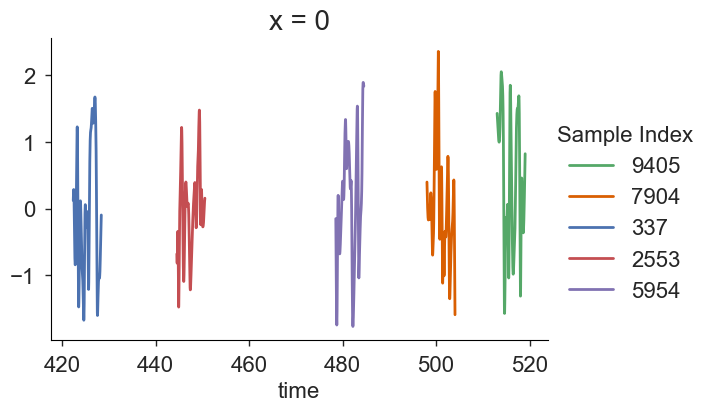

In [11]:
fig, ax = plt.subplots(figsize=(7,4), constrained_layout=True)
for mt in macro_trainers:
    mt.isel(x=0).plot(label=mt.sample_index, ax=ax)
ax.legend(title="Sample Index", loc=(1., .1), )

### Get Test Datasets

We'll do the same thing to get test trajectories, but we'll get more samples.

In [12]:
test_kwargs = {
    "n_samples": 20, # number of samples to grab
    "n_steps": 500, # how long are the sample trajectories to optimize over
    "n_spinup": 100, # how long is the pre-prediction spinup period
    "random_seed": 10,
}

In [13]:
testers, _ = get_samples(
    xda=tester,
    **test_kwargs
)    

## CostFunction and Optimization Configuration

Here we have to setup a nested dictionary that will specify the many subcomponents that are important for the optimization problem.
The subcomponents are:

1. The `macro_training` configuration, specifying how to do the optimization. We'll break this down piece by piece.

2. The generic ESN configuration. Basically, everything that needs to be fixed other than the parameters we want to optimize. These options are passed to either [xesn.ESN](generated/xesn.ESN.rst) or [xesn.LazyESN](generated/xesn.LazyESN.rst), depending on which model is being used.

3. The `training` options, consisting of any of the optional keyword arguments that get passed to
   [ESN.train()](generated/xesn.ESN.train.rst) or [LazyESN.train()](generated/xesn.LazyESN.train.rst).

4. The `testing` options, this is optional, but allows us to use
   [CostFunction.evaluate()](generated/xesn.CostFunction.evaluate.rst)
   to operate the ESN on the test dataset after we're done with model development.

### Macro Training Configuration

**Parameters**

First, we set the parameters to be optimized, along with bounds for the optimization.
In this example, we'll set the five uncertain scalar parameters noted in
[the methods](methods.rst#macro-scale-parameters).

- Input factor: $\sigma \in [0, 2]$

- Adjacency factor: $\rho \in [0, 2]$

- Bias factor: $\sigma_b \in [0, 2]$

- Leak rate: $\alpha \in [0, 1]$

- Tikhonov parameter: $\beta \in [10^{-12}, 1]$

In [14]:
optim_parameters = {
    "input_factor": [0., 2.],
    "adjacency_factor": [0., 2.],
    "bias_factor": [0., 2.],
    "leak_rate": [0., 1.],
    "tikhonov_parameter": [1.e-12, 1.],
}

**Transformations**

Additionally, we can set transformations so that the optimization is performed in a transformed space.
Currently, there are only two available options: ``"log10"`` and ``"log"``.
This allows us to explore a space that spans several orders of magnitude, which is particularly nice for the regularization parameter.

In [15]:
optim_transformations = {
    "tikhonov_parameter": "log10",
}

**Cost Terms**

Here we formulate the cost function. Currently, the cost function is made up of two possible
terms:
$$
\mathcal{J}_\text{macro}(\theta) =
\dfrac{1}{N_\text{macro}}\sum_{j=1}^{N_\text{macro}}
\left\{
    \gamma_1\text{NRMSE}(j) + \gamma_2 \text{PSD}\_\text{NRMSE}(j)
\right\}
$$
where

- $\mathbf{\theta} = \left(\sigma, \rho, \sigma_b, \alpha, \beta\right)^T$ is our vector of parameters to be optimized

- $N_\text{macro}$ = `forecast_kwargs["n_samples"]` is the number of sample forecasts

- $\gamma_1$ and $\gamma_2$ determine the overall weighting for the NRMSE and
  PSD\_NRMSE terms, respectively
  
- $\text{NRMSE}(j)$ is the normalized root-mean-square error of sample forecast $j$, which is
  defined as follows
  $$
  \text{NRMSE}(j) = \sqrt{
      \dfrac{1}{N_v N_\text{steps}}
      \sum_{n=1}^{N_\text{steps}}
      \sum_{i=1}^{N_v}
      \left(
          \dfrac{\hat{v}_j(i, n) - v_j(i, n)}{SD_j}
      \right)^2 } \, ,
  $$
  where
  
  - $i$ is the index for each non-time index ($N_v = 12$ in our example)
  
  - $n$ is the temporal index, and $N_\text{steps}$ = `forecast_kwargs["n_steps"]` is the
    length of each sample forecast in terms of the number of time steps
    
  - $j$ is the index for each sample forecast
  
  - $SD_j$ is the standard deviation of the sample forecast, taken over space and time
   $$
   SD_j = \sqrt{
    \dfrac{
        \sum_{i=1}^{N_v}\sum_{n=1}^{N_{\text{steps}}}\left(v_j(i, n) - \mu_j\right)^2
       }
       {(N_{\text{steps}}-1)(N_v-1)}
        }
   $$
   where $\mu_j$ is the sample average taken over space and time
   $\mu_j =
   \dfrac{1}{N_v N_\text{steps}}
   \sum_{n=1}^{N_\text{steps}}
   \sum_{i=1}^{N_v}
   v_j(i,n)$
   
- $\text{PSD}\_\text{NRMSE}(j)$ is the NRMSE of the Power Spectral Density (PSD) for each sample.
  The terms is as follows
  $$
  \text{PSD}\_\text{NRMSE}(j) = \sqrt{
      \dfrac{1}{N_K N_\text{steps}}
      \sum_{n=1}^{N_\text{steps}}
      \sum_{i=1}^{N_K}
      \left(
          \dfrac{\hat{\psi}_j(k, n) - \psi_j(k, n)}{SD_j(k)}
      \right)^2 } \, ,
  $$
  where
  
  - indices $j$, $n$ are the same as for NRMSE
  
  - $k$ is the index for each spectral mode of the PSD
  
  - $\psi_j(k,n)$ is the $k^{th}$ mode's amplitude, for sample $j$ at time step $n$
  
  - $SD_j(k)$ is defined similarly as above, but in spectral space, and note that each
    mode is normalized separately as different modes can vary by vastly different orders of
    magnitude
    

<div class="alert alert-info">
    
Note

The motivation for prioritizing the PSD in the cost function stems from the follow studies:

1. <cite data-cite="platt_constraining_2023">Platt et al., (2023)</cite>,
   showed that by prioritizing invariants like the Lyapunov Exponent, or possibly the PSD,
   fewer sample trajectories are needed during the optimization process in order to get a good parameter set.
   
2. <cite data-cite="smith_temporal_2023">Smith et al., (2023)</cite>,
   showed that prioritizing the Kinetic Energy spectrum (similar to the PSD) of turbulent geophysical fluids encouraged
   ESN parameter choices that better represented small scale processes in the flow.

</div>

In this example, we employ a simple mixture of the two cost terms, setting
$\gamma_1 = \gamma_2 = 1$.
Note that getting the right balance of these two terms is likely to be application dependent.

In [16]:
cost_terms = {"nrmse": 1., "psd_nrmse": 1.}

### ESN Configuration and Training Options

As noted above, here we set everything that we want to stay fixed in the
[ESN](generated/xesn.ESN.rst) or [LazyESN](generated/xesn.LazyESN.rst) during optimization.
Note that the values for the optimization parameters that we choose here have *no influence* on the optimization whatsoever.
Instead, the optimization is initialized using a sophisticated random sampling strategy, see [here](https://smt.readthedocs.io/en/latest/_src_docs/sampling_methods.html) for options.

In [17]:
esn_kwargs = {
    "n_input": model.N,
    "n_output": model.N,
    "n_reservoir": 1000,
    "leak_rate": 0.5, # value doesn't matter
    "tikhonov_parameter": 1e-6, # value doesn't matter
    "input_kwargs":{
        "factor": 0.5, # value doesn't matter
        "normalization": "svd",
        "distribution": "uniform",
        "random_seed": 0,
    },
    "adjacency_kwargs":{
        "factor": 0.5, # value doesn't matter
        "normalization": "svd",
        "distribution": "uniform",
        "is_sparse": True,
        "connectedness": 5,
        "random_seed": 1,
    },
    "bias_kwargs":{
        "factor": 0.5, # value doesn't matter
        "distribution": "uniform",
        "random_seed": 2,
    },
}

In [18]:
training_kwargs = {
    "n_spinup": 0,
    "batch_size": 20_000,
}

### The `config` dictionary 

At last, we specify the entire configuration by pulling all of the subcomponents together.

Note that the `macro_training` section also needs a `forecast` subsection, which we specified earlier to generate the samples.
The `forecast_kwargs` used to generate samples and during optimization must be consistent with one another.

In [19]:
config = {
    "macro_training": {
        "parameters": optim_parameters,
        "transformations": optim_transformations,
        "forecast": forecast_kwargs,
        "cost_terms": cost_terms,
    },
    "esn": esn_kwargs, # note this section would be labelled "lazyesn" if that model was used
    "training": training_kwargs,
    "testing": test_kwargs,
}

## Create a [CostFunction](generated/xesn.CostFunction.rst)

In [20]:
from xesn import CostFunction, ESN

In [21]:
cf = CostFunction(
    ESN=ESN, # this could also be xesn.LazyESN
    train_data=trainer,
    macro_data=macro_trainers,
    config=config,
    test_data=testers,
)

Now lets evaluate the cost function on a guessed set of parameters.

In [22]:
p_guess = {
    "input_factor": 0.5,
    "adjacency_factor": 0.9,
    "bias_factor": 0.,
    "leak_rate": 0.5,
    "tikhonov_parameter": 1.e-6,
}

Note that when we call the cost function we pass `is_transformed=False` because we have not transformed the `"tikhonov_parameter"` to `log10` space, although this transformation will occur under the hood during optimization.

In [23]:
cf(list(p_guess.values()), is_transformed=False)

array([[7843.79531606]])

This is the evaluated cost of our random configuration.
Note that under the hood, the [CostFunction](generated/xesn.CostFunction.rst):

- creates an ESN

- assigns the parameter values for this sample

- builds and trains the readout weights

- makes `forecast_kwargs["n_samples"]` sample forecasts

- computes the cost compared to the provided `macro_data` datasets

### Visualizing the Cost

Here we go through the steps outlined above to give a visual impression of how our model performed on a single sample, in order to see what the NRMSE and PSD_NRMSE might look like.

In [24]:
ds = cf.evaluate(p_guess)
ds = ds.rename({
    "prediction": "guess",
    "nrmse": "nrmse_guess",
    "psd_prediction": "psd_guess",
    "psd_nrmse": "psd_nrmse_guess",
})

First, visually compare the prediction and the truth from our `macro_training` set.

In [25]:
def plot_visual_comparison(xds, varnames, sample):
    
    nrows = len(xds.x)
    fig, axs = plt.subplots(nrows, 1, figsize=(8, nrows*1), constrained_layout=True, sharex=True, sharey=True)
    
    for i, ax in enumerate(axs):
        for key in varnames:
            color = "k" if key == "truth" else None
            xds[key].isel(x=i, sample=sample).plot(ax=ax, color=color, label=key)
        ax.set(ylabel="", xlabel="", title="")
    ax.set(xlabel="Forecast Time (MTU)", ylim=(-4,4))
    axs[0].legend(loc=(.25,.87),ncol=3)

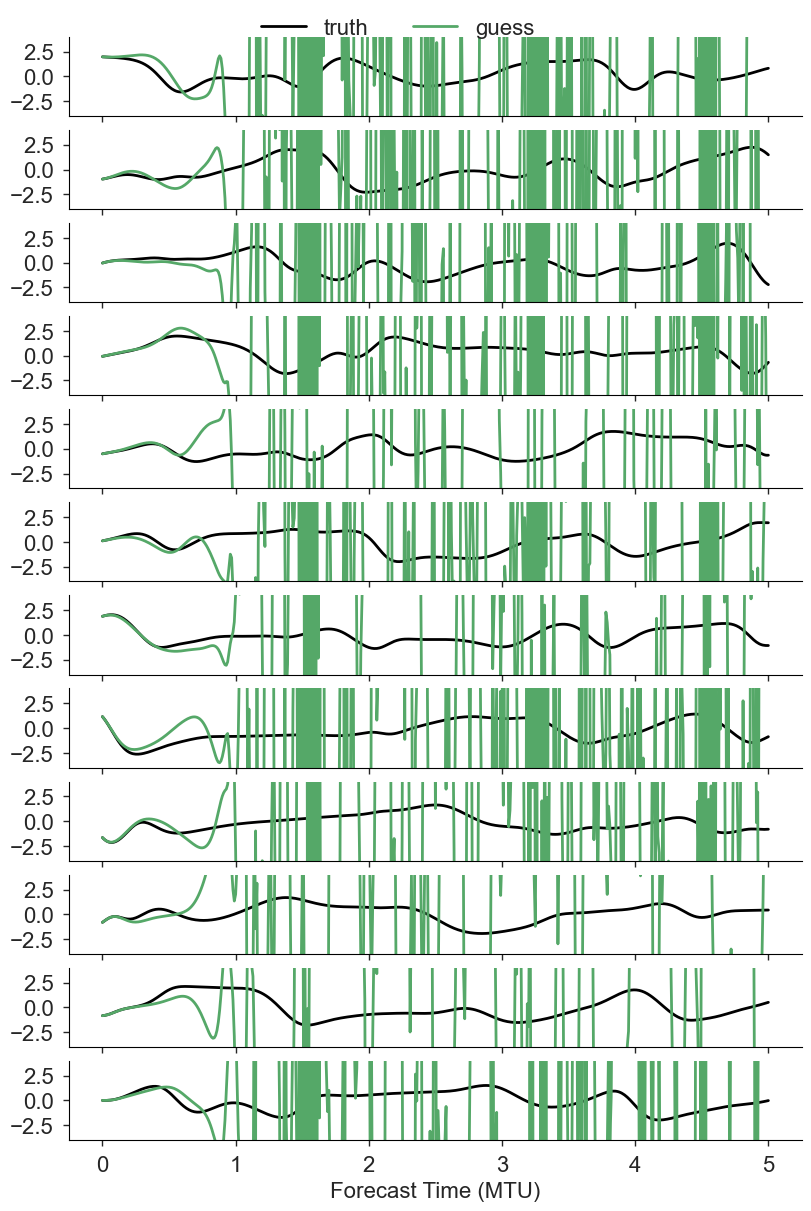

In [26]:
plot_visual_comparison(ds, varnames=["truth", "guess"], sample=0)

Now compute the NRMSE as a function of forecast time, and the PSD as a function of wavenumber.

In [27]:
import seaborn as sns

In [28]:
def plot_metrics(xds, varnames):
    
    fig, axs = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)

    ekeys = list(v for v in varnames if v != "truth")
    for key in ekeys:
        ekey = f"nrmse_{key}"
        sns.lineplot(
            data=xds[ekey].to_dataset(name="NRMSE").to_dataframe().reset_index(),
            x="ftime",
            y="NRMSE",
            ax=axs[0],
            label=key,
        )
    for key in varnames:
        pkey = f"psd_{key}"
        sns.lineplot(
            data=xds[pkey].to_dataset(name="PSD").to_dataframe().reset_index(),
            x="k1d",
            y="PSD",
            ax=axs[1],
            color="k" if "truth" in key else None,
            label=key,
        )
    axs[0].set(ylim=(-.1, 2), xlabel="Forecast Time (MTU)")
    axs[0].axhline(y=.2, color="gray")
    axs[1].set(yscale="log", xlabel="Wavenumber Index")
    [ax.legend() for ax in axs];
    return fig, axs

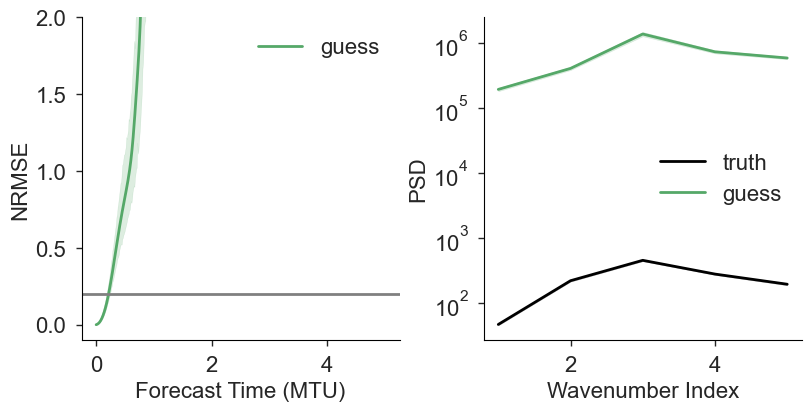

In [29]:
plot_metrics(ds, varnames=["truth", "guess"]);

It doesn't look like a very good guess. We could also plot the PSD_NRMSE, but it is maybe more intuitive to visually compare PSD directly in this case.

## Macro-Scale Parameter Optimization

At last, we provide our CostFunction object to the [optimize](generated/xesn.optimize.rst) function, 
which simply passes it to the surrogate modeling toolbox's
[Efficient Global Optimization](https://smt.readthedocs.io/en/latest/_src_docs/applications/ego.html)
class, which performs Bayesian Optimization.
All keyword arguments to [optimize](generated/xesn.optimize.rst)
are passed to `smt.applications.EGO`, see a list of all possible options
[here](https://smt.readthedocs.io/en/latest/_src_docs/applications/ego.html#options).

In [30]:
from xesn import optimize

In [31]:
%%time
p_opt = optimize(
    cost_function=cf,
    # all other kwargs get passed to smt.EGO
    n_iter=5,
    n_doe=10,
    n_parallel=4,
    random_state=5,
)

/Users/tsmith/work/xesn/xesn/esn.py:514: LinAlgWarning: Ill-conditioned matrix (rcond=5.24221e-22): result may not be accurate.
  Wout = solve(rbar.T, ybar.T, **kw)
/Users/tsmith/work/xesn/xesn/esn.py:514: LinAlgWarning: Ill-conditioned matrix (rcond=8.35488e-21): result may not be accurate.
  Wout = solve(rbar.T, ybar.T, **kw)



 --- Optimization Results ---

Optimal inputs:
	input_factor                : 0.416148253752975
	adjacency_factor            : 0.17414646123547528
	bias_factor                 : 1.7740966174002968
	leak_rate                   : 0.4253588205773788
	tikhonov_parameter          : 1.5598280907338211e-07

Approximate cost minimum:
	[1.56521136]

CPU times: user 30min 46s, sys: 1min 10s, total: 31min 57s
Wall time: 3min 22s


## Evaluate the Optimized and Guessed ESNs on the Test Datasets

Now that we are done with model tuning and development, we can evaluate both the optimized and guessed ESN configurations on the test data.

In [32]:
%%time
ds = cf.evaluate(p_guess, use_test_data=True)
ods = cf.evaluate(p_opt, use_test_data=True)

CPU times: user 3min 25s, sys: 8.83 s, total: 3min 34s
Wall time: 20.4 s


In [33]:
ds = ds.rename({
    "prediction": "guess",
    "nrmse": "nrmse_guess",
    "psd_prediction": "psd_guess",
    "psd_nrmse": "psd_nrmse_guess",
})
ods = ods.rename({
    "prediction": "optimized",
    "nrmse": "nrmse_optimized",
    "psd_prediction": "psd_optimized",
    "psd_nrmse": "psd_nrmse_optimized",
})

In [34]:
for key in ods.data_vars:
    if "optimized" in key:
        ds[key] = ods[key]

First the visual comparison

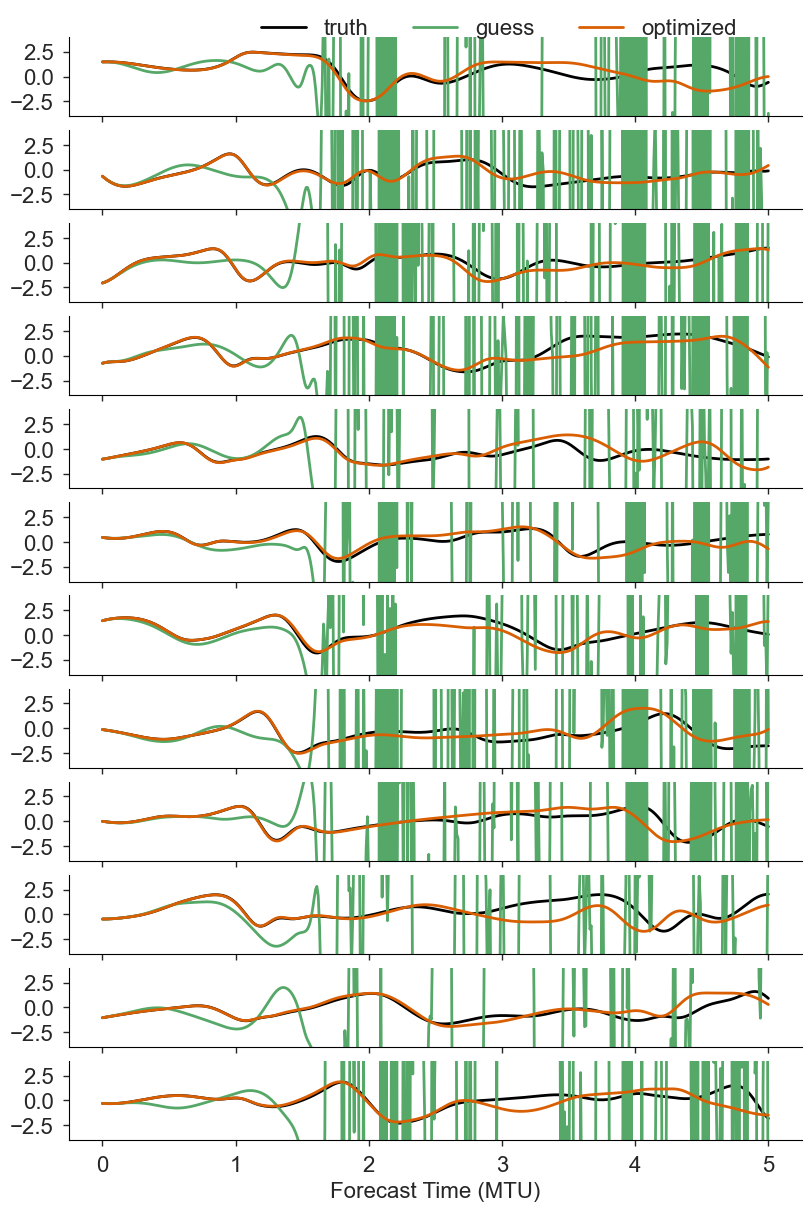

In [35]:
plot_visual_comparison(ds, varnames=["truth", "guess", "optimized"], sample=0)

Now compare NRMSE and PSD over the test samples 

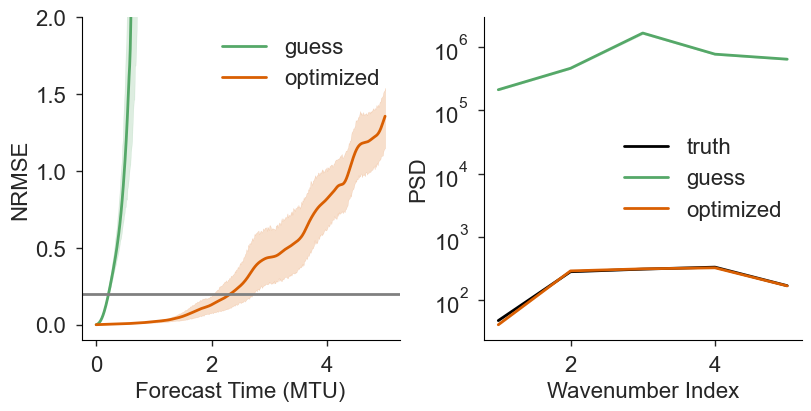

In [36]:
plot_metrics(ds, varnames=["truth", "guess", "optimized"]);

With the optimized architecture, we hit NRMSE=0.2 at around 2.5 MTU, and the PSD looks much closer to the truth